In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Adversarial attacks and robustness for quantum machine learning
===============================================


This demo is based on the paper *A Comparative Analysis of Adversarial
Robustness for Quantum and Classical Machine Learning Models* by M.
Wendlinger, K. Tscharke and P. Debus, which dives into the world of
adversarial attacks on quantum computers to find relations to classical
adversarial machine learning. In the following, we briefly cover the
necessary theoretical baselines of adversarial attacks on classification
networks before giving a hands-on example of how to construct such an
attack and how we can make QML models more robust. Let's go!

![](../_static/demonstration_assets/adversarial_attacks_QML/QAML_overview.png){.align-center
width="80.0%"}


# What are adversarial attacks?

Adversarial attacks are small, carefully crafted perturbations to input
data that lead to high rates of misclassification for machine learning
models, while the data seems to be identical to the original for human
observers. In particular, images are sensitive to this type of attack,
as small manipulations of the pixels can fool a classifier without any
changes being visible to humans. A typical example of an adversarial
attack is shown in the picture above, where an image of a panda is
manipulated by adding a small noise to each pixel. The original image is
correctly classified as \"Panda,\" while the image with tiny
manipulations is falsely classified as \"Gibbon\" (the noise is
magnified in the figure so we can actually see it). This example is
adapted from a famous paper showing the vulnerability of classical
machine learning models to adversarial attacks.

Mathematically, the goal of an (untargeted) attack is to achieve a
misclassification of the model such that a sample $x$ leads to a
predicted label $y' \neq y$ that is not the true label $y.$ This is
achieved by finding the perturbation $\delta\in\Delta$ to the original
input that maximizes the loss of the true class. For a loss function
$\mathcal{L},$ a model $f: \mathbb{R}^{D} \to \mathbb{R}^K$ (mapping
$D$-dimensional input to
[softmax](https://en.wikipedia.org/wiki/Softmax_function) probability
scores of $K$ classes with model parameters $\theta^*$), the objective
of the untargeted attack is:

$$\delta \equiv \; \underset{\delta^{\prime} \in \Delta}{\operatorname{argmax}} \;\mathcal{L}\left(f\left(x+\delta^{\prime} ; \theta^*\right), y\right).$$

Later, when we show how to actually construct such an attack, we will
revisit this equation. For an adversarial attack to be considered
useful, it must hold that the modifications to the input elements are
imperceptible, i.e. that
$\Delta=\{\delta \in \mathbb{R}^{D}: \| \delta\|_{\infty} \le \varepsilon\},$
where $\varepsilon$ is some small bound, typically below $0.1.$


# Why are adversarial attacks dangerous?

Machine learning (ML) is becoming essential in many security-critical
applications, for example in
[cybersecurity](https://arxiv.org/abs/1901.03407), the [medical
sector](https://arxiv.org/abs/1606.05718), or [autonomous
vehicles](https://arxiv.org/abs/1604.07316). In cybersecurity, ML models
are used, amongst others, for malware detection or the prevention of
attacks on networks. Given their critical roles, any successful attack
of these ML models can lead to severe consequences, ranging from
financial losses and privacy violations to threats to human life. As we
have seen above, adversarial attacks are imperceptible to humans, and
hence difficult to detect. For this reason, it is essential that ML
models in security-critical applications are robust against these types
of attacks.

[Quantum machine learning
(QML)](%5B/whatisqml%5D(https://pennylane.ai/qml/whatisqml/)) has been
shown to have theoretical advantages over classical ML methods and is
becoming increasingly popular. However, first works in this direction
suggest that QML suffers from the same vulnerabilities as classical ML.
How the vulnerability of QML models relates to classical models and how
robust the models are in comparison is evaluated in. But enough talk,
let's see how we can actually attack a QML model!


# Let's see this in action!

## Setting up the environment

For this tutorial, we will use the PennyLane
`~pennylane.qnn.TorchLayer`{.interpreted-text role="class"} class to
perform circuit operations and optimizations with the PyTorch backend.
Thus, we need to import the torch library alongside PennyLane:


In [2]:
import pennylane as qml
from pennylane import numpy as np
import torch
from matplotlib import pyplot as plt

# Visualization of the dataset

As in the paper, we make use of the
[PlusMinus](https://pennylane.ai/datasets/single-dataset/plus-minus)
dataset (available via [PennyLane
Datasets](https://pennylane.ai/datasets/)), which serves as a good
baseline for evaluating a QML image classification model's ability to
find useful features in the input. It also allows us to define the
usefulness of attacks on the QML model while being low-dimensional
enough to perform scalable training (more info on the dataset can be
found in). It consists of four classes of $16\times16$ pixel grayscale
images which show one of the four symbols $\{+,-,\vdash,\dashv\}.$ Below
we visualize one sample of each class to get an understanding of the
dataset.

The data can be loaded directly from [PennyLane
Datasets](https://pennylane.ai/datasets/) for easy integration into
PennyLane circuits and optimization code.


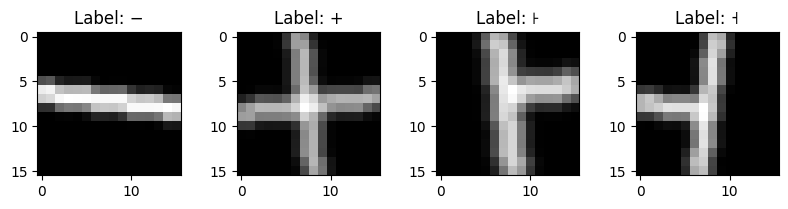

In [3]:
# we can use the dataset hosted on PennyLane
[pm] = qml.data.load('other', name='plus-minus')

X_train = pm.img_train  # shape (1000,16,16)
X_test = pm.img_test  # shape (200,16,16)
Y_train = pm.labels_train  # shape (1000,)
Y_test = pm.labels_test  # shape (200,)

# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [
    (X_train[Y_train == 0])[0],
    (X_train[Y_train == 1])[0],
    (X_train[Y_train == 2])[0],
    (X_train[Y_train == 3])[0],
]
y_vis = [0, 1, 2, 3]


# later when we train the model we include the predictions as well, so let's just add the functionality here
def visualize_data(x, y, pred=None):
    n_img = len(x)
    labels_list = ["\u2212", "\u002b", "\ua714", "\u02e7"]
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    for i in range(n_img):
        axes[i].imshow(x[i], cmap="gray")
        if pred is None:
            axes[i].set_title("Label: {}".format(labels_list[y[i]]))
        else:
            axes[i].set_title("Label: {}, Pred: {}".format(labels_list[y[i]], labels_list[pred[i]]))
    plt.tight_layout(w_pad=2)
    # plt.show()


visualize_data(x_vis, y_vis)

# Building the QML circuit for classification

We will make use of a
`data-reuploading <tutorial_data_reuploading_classifier>`{.interpreted-text
role="doc"} scheme to encode the 256 input pixels into the latent space
of the quantum classifier. To this end, the
`~pennylane.StronglyEntanglingLayers`{.interpreted-text role="class"}
template provides an easy-to-use structure for the circuit design. The
output of our classifier is a four-dimensional vector resulting from
Pauli Z oberservables along the first four qubits. These outputs
(unnormalized probability scores --- i.e. logits) are then used in the
[CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
function to optimize the model parameters. Together with the PyTorch
integration mentioned above, the classifier code looks like the
following:


In [4]:
#### Hyperparameters ####
input_dim = 256
num_classes = 4
num_layers = 32
num_qubits = 8
num_reup = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


class QML_classifier(torch.nn.Module):
    """
    Class for creating a quantum machine learning (classification) model based on the StronglyEntanglingLayers template.

    Args:
        input_dim: the dimension of the input samples
        output_dim: the dimension of the output, i.e. the numbers of classes 
        num_qubits: the number of qubits in the circuit
        num_layers: the number of layers within the StronglyEntanglingLayers template
    """
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(1337)  # fixed seed for reproducibility
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = qml.device("lightning.qubit", wires=self.num_qubits)
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(
                weights=weights * inputs + bias, wires=range(self.num_qubits)
            )
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

        param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
        init_vals = {
            "weights": 0.1 * torch.rand(self.weights_shape),
            "bias": 0.1 * torch.rand(self.weights_shape),
        }

        # initialize the quantum circuit
        self.qcircuit = qml.qnn.TorchLayer(
            qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
        )

    def forward(self, x):
        inputs_stack = torch.hstack([x] * num_reup)
        return self.qcircuit(inputs_stack)

Using device: cuda


# Training the classifier

The 'test' set will be used as validation in each training step to
verify the generalization capabilities of our classifier.


In [ ]:
#### Hyperparameters ####
learning_rate = 0.1
epochs = 4
batch_size = 20

# we use a subset of the training and validation data for this tutorial to speed up the training
feats_train = torch.from_numpy(X_train[:200]).reshape(200, -1).to(device)
feats_test = torch.from_numpy(X_test[:50]).reshape(50, -1).to(device)
labels_train = torch.from_numpy(Y_train[:200]).to(device)
labels_test = torch.from_numpy(Y_test[:50]).to(device)
num_train = feats_train.shape[0]

# initialize the model, loss function and optimization algorithm (Adam optimizer)
qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)
num_batches = feats_train.shape[0] // batch_size


# set up a measure for performance
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc += 1
    acc = acc / len(labels)
    return acc


# generate randomly permutated batches to speed up training
def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind


# display accuracy and loss after each epoch (to speed up runtime, only do this for first 100 samples)
def print_acc(epoch, max_ep=4):
    predictions_train = [qml_model(f) for f in feats_train[:50]]
    predictions_test = [qml_model(f) for f in feats_test]
    cost_approx_train = loss(torch.stack(predictions_train), labels_train[:50])
    cost_approx_test = loss(torch.stack(predictions_test), labels_test)
    acc_approx_train = accuracy(labels_train[:50], predictions_train)
    acc_approx_test = accuracy(labels_test, predictions_test)
    print(
        f"Epoch {epoch}/{max_ep} | Approx Cost (train): {cost_approx_train:0.7f} | Cost (val): {cost_approx_test:0.7f} |"
        f" Approx Acc train: {acc_approx_train:0.7f} | Acc val: {acc_approx_test:0.7f}"
    )


print(
    f"Starting training loop for quantum variational classifier ({num_qubits} qubits, {num_layers} layers)..."
)

# optimize over model parameters for given number of epochs
for ep in range(0, epochs):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs)

Starting training loop for quantum variational classifier (8 qubits, 32 layers)...
Epoch 0/4 | Approx Cost (train): 1.3883214 | Cost (val): 1.3875420 | Approx Acc train: 0.1600000 | Acc val: 0.1200000


# Evaluation - benign data


In [ ]:
# show accuracy
x_vis_torch = torch.from_numpy(np.array(x_vis).reshape(4, -1))
y_vis_torch = torch.from_numpy(np.array(y_vis))
benign_preds = [qml_model(f) for f in x_vis_torch]

benign_class_output = [torch.argmax(p) for p in benign_preds]
visualize_data(x_vis, y_vis, benign_class_output)

# Let's break stuff!

As described before, the mathematical notation for an adversarial attack
is as follows:

$$\delta \equiv \; \underset{\delta^{\prime} \in \Delta}{\operatorname{argmax}} \;\mathcal{L}\left(f\left(x+\delta^{\prime} ; \theta^*\right), y\right).$$

This equation can be summarized in a simple step-by-step recipe. In
basic terms, we perform a forward and backward pass through the model
and loss function (just like we do during training) for the specific
samples that we want to find perturbations for. The difference to
training steps is that the gradients we calculate are **with respect to
the input features** of the data samples. Using these gradients, we find
the direction of ascent in the loss function (as we want to force high
losses, i.e. bad model performance for the specific samples). Finally,
we clip the delta (perturbations), such that they lie within the epsilon
boundary we set beforehand (this is just some hyperparameter wich limits
the attack strength). All of these steps can be seen in the code below:


In [ ]:
# simple implementation of projected gradient descent (PGD) attack (without randomized starting points — cf. BIM)
# for an introduction to PGD, see https://adversarial-ml-tutorial.org/adversarial_examples/#projected-gradient-descent
def PGD(model, feats, labels, epsilon=0.1, alpha=0.01, num_iter=10):

    # initialize image perturbations with zero
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f) for f in feats_adv]

        # forward & backward pass through the model, accumulating gradients
        l = loss(torch.stack(outputs), labels)
        l.backward()

        # use gradients with respect to inputs and clip the results to lie within the epsilon boundary
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

# Evaluation --- model under attack


In [ ]:
perturbations = PGD(model=qml_model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.1)
perturbed_x = x_vis_torch + perturbations

# check model performance
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 16, 16), y_vis, adversarial_class_output)

We can see the devastating effect of a simple PGD (projected gradient
descent) attack using a perturbation strength $\varepsilon=0.1,$ where
the model misclassifies each of the four samples we used for
visualization of the dataset. For humans, the images are still very
easily classifiable, the perturbations look mostly like random noise
added to the images. All in all, the accuracy of the model for the
perturbed trainset decreases to around $0.1,$ so almost all samples of
the dataset are misclassified!

Using the code above, you can try the attack on your own and check which
samples are more robust against attacks and which labels the model
(wrongly) assigns to the data. The remaining question is: Can we defend
against such attacks? How can we train our (QML) models to be more
robust against adversarial attacks? This is a field of much active
research and in general a very hard problem to solve for different kinds
of attacks, model architectures and input data, but a very simple
approach is given below.


# Increasing the robustness of QML models

The easiest way to make our model aware of slight modifications is to
simply include the perturbed images into the training dataset (this can
be seen as data augmentation and is often done in classical machine
learning using noise). That way, the model is expected to be more robust
against samples that were constructed using the same attack without
changing anything in the model architecture itself; this method is
called **adversarial (re)training**.


In [ ]:
adv_dataset = (
    PGD(model=qml_model, feats=feats_train[:20], labels=labels_train[:20], epsilon=0.1)
    + feats_train[:20]
)

feats_retrain = torch.cat((feats_train, adv_dataset))
labels_retrain = torch.cat((labels_train, labels_train[:20]))
epochs_retraining = 2

for ep in range(0, epochs_retraining):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep, max_ep=2)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_retrain[batch_ind[it]]
        labels_train_batch = labels_retrain[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs_retraining, max_ep=2)

# Evaluation of the retrained model


In [ ]:
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 16, 16), y_vis, adversarial_class_output)

We can see that the model now correctly classifies three out of the four
perturbed input images. As before, you can adapt the code above and test
the retrained model for the whole dataset to see how much the accuracy
under attack improves overall.


# Conclusion

In this demo we saw how to perform adversarial attacks on quantum
variational classification models. The resulting perturbed images (which
--- for humans --- still closely resemble the original ones) result in
large misclassification rates of the QML models, showing the
vulnerability of such models to adversarial attacks. Consequently, we
showcased one possibility to increase the adversarial robustness using
adversarial retraining, which led the model under attack to perform
better.

While this method does seem useful, it needs to be noted that this is a
very basic approach (just include the pertubed images in the trainset,
duh!) and might not work equally well for a different attack or slightly
changed epsilon values. There are approaches (e.g. using Lipschitz
regularization as shown in) that have the potential to be more effective
in increasing the robustness, but this is still a field of ongoing
research, and many different approaches are waiting to be discovered!


# References


# About the authors
